In [71]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

## Build loss function

In [78]:
int(action==2)

1

In [90]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [ ]:
import json
import os
import sys

import numpy as np
import tensorflow as tf

import tetris_api

ACTIONS = {3: 'up', 2: 'right', 1: 'left', 0: 'down'}

if sys.version_info.major == 2:
    range = xrange

# tetris
num_cols = 4
num_rows = 16

# learning params
gamma = 0.9
learning_rate = 1e-2
max_ep = 99999 # how many steps to take
num_hidden = 25
update_frequency = 50 # after how many games to update model

# create environment
env = tetris_api.PyTetrisEnv()
tf.reset_default_graph()  # clear the Tensorflow graph.

# TODO build graph here
# build nodes
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, num_cols*num_rows])
actions = tf.placeholder(tf.int32, shape=[None])
rewards = tf.placeholder(tf.float32, shape=[None])

# 1st layer 
W1 = weight_variable([num_cols*num_rows,num_hidden])
b1 = bias_variable([num_hidden])
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
 
# output 
W2 = weight_variable([num_hidden,4])
b2 = bias_variable([4])
y = tf.matmul(h1,W2) + b2
output = tf.nn.softmax(y)

# get prob for chosen action
# first need to figure out indices of all of the chose actions
# from the flattened array
action_indices = (tf.range(0, tf.shape(y)[0]) * tf.shape(y)[1]) + actions
prob_for_picked_actions = tf.gather(tf.reshape(y, [-1]), action_indices)

# loss function
cross_entropy = -tf.reduce_mean(tf.log(prob_for_picked_actions) * rewards)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

sess.run(tf.global_variables_initializer())


import tf_rl_utils
env = tetris_api.PyTetrisEnv()
all_ep_history = []
game_num = 0
game_rewards = []
action_history = []
while True:
    s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
    s = tf_rl_utils.prepro(s_2D)
    prior_state = np.zeros_like(s)
    ep_history = []
    for j in range(max_ep):
        # determine action
        del_state = s - prior_state 
        a_dist = sess.run(output, feed_dict={x: [del_state]})
        picked_action_prob = np.random.choice(a_dist[0], p=a_dist[0])
        action = np.argmax(a_dist == picked_action_prob)
        action_history.append(action)
        
        # take action
        prior_state = s
        s_2D, r, done, _ = env.step(ACTIONS[action]) 
        s = tf_rl_utils.prepro(s_2D)
        
        ep_history.append(np.array([del_state, action, r]))
        if done:
            # game_states = []
            ep_history = np.array(ep_history)
            ep_history[:, 2] = tf_rl_utils.discount_rewards(ep_history[:, 2], gamma=gamma)
            all_ep_history.append(ep_history)
            game_rewards.append(np.sum(ep_history[:, 2]))
            ep_history = []

            its_time_to_update_weights = ((game_num % update_frequency) == 0 and (game_num != 0))
            if its_time_to_update_weights:
                print game_num, np.mean(game_rewards[game_num-10:game_num])
                all_ep_history = np.vstack(all_ep_history)
                feed_dict = {rewards: all_ep_history[:, 2],
                             actions: all_ep_history[:, 1],
                             x: np.vstack(all_ep_history[:, 0])}
                sess.run(train_step, feed_dict=feed_dict)
                all_ep_history = []
            break
    game_num += 1

50 1650.7893604
100 1310.44357428
150 1418.87603851
200 1185.89940513
250 1325.15335831
300 1146.29809384
350 1060.66277094
400 963.196919688
450 1022.74609178
500 1067.34627542
550 858.084313888
600 878.519602243
650 857.329292135
700 827.237706747
750 861.74989708
800 826.783127801
850 737.468891539
900 813.284097262
950 862.570167448
1000 684.143675812
1050 726.521908315
1100 741.725020824
1150 708.217619875
1200 866.206162878
1250 808.989572501
1300 696.638312465
1350 654.784401045
1400 664.192146248
1450 616.274297615
1500 747.509415136
1550 732.02056987
1600 649.113250299
1650 751.699364247
1700 757.777520477
1750 674.706504947


In [88]:



# learning params
gamma = 0.9
learning_rate = 1e-2
max_ep = 99999 # how many steps to take
num_hidden = 25
update_frequency = 50 # after how many games to update model

# create environment
env = tetris_api.PyTetrisEnv()
tf.reset_default_graph()  # clear the Tensorflow graph.

# TODO build graph here
# build nodes
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, num_cols*num_rows])
actions = tf.placeholder(tf.int32, shape=[None])
rewards = tf.placeholder(tf.float32, shape=[None])

# 1st layer 
W1 = weight_variable([num_cols*num_rows,num_hidden])
b1 = bias_variable([num_hidden])
h1 = tf.matmul(x, W1) + b1







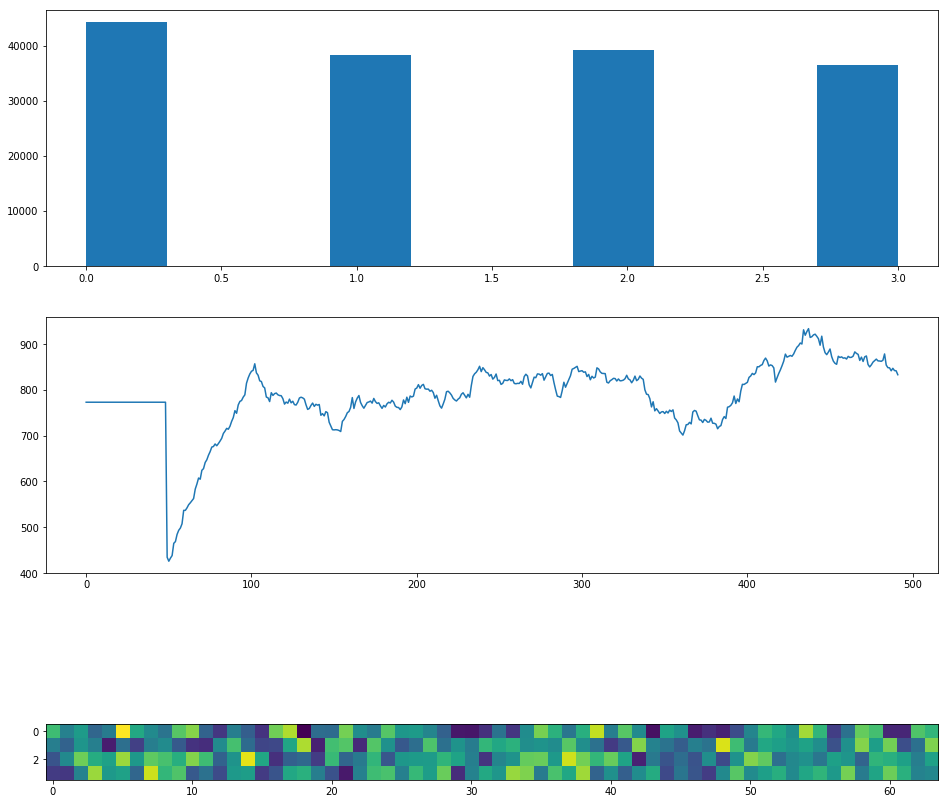

In [83]:
fig,(ax0,ax1,ax2) = plt.subplots(3,1, figsize=(16,16))
ax0.hist(action_history)

# game rewards
# ax1.plot(game_rewards)
game_rewards_s = pd.Series(game_rewards)
rolling_game_rewards = game_rewards_s.rolling(50).mean().fillna(game_rewards_s.mean())
ax1.plot(rolling_game_rewards)

# weights
_W = sess.run(W)
c = ax2.imshow(_W.T)
# c.colorbar()

In [81]:
s, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
s = tf_rl_utils.prepro(s)
prior_state = np.zeros_like(s)
ep_history = []
for j in range(max_ep):
    # determine action
    del_state = s - prior_state 
    a_dist = sess.run(output, feed_dict={x: [del_state]})
    picked_action_prob = np.random.choice(a_dist[0], p=a_dist[0])
    action = np.argmax(a_dist == picked_action_prob)

    # take action
    prior_state = s
    s, r, done, _ = env.step(ACTIONS[action]) 
    s = tf_rl_utils.prepro(s)

    ep_history.append(np.array([del_state, action, r]))
    if done:
        break

ep_history = np.array(ep_history)
print ep_history[:,2].sum()

-1.0


In [58]:
s

0        189.996515
1        389.506989
2        589.676538
3        389.999891
4        189.999659
5        389.246293
6        189.995698
7         -9.999960
8        189.999116
9        989.787194
10       589.985570
11       789.389682
12       789.556291
13       189.951450
14        -9.999997
15        -9.999945
16       189.984765
17       189.998149
18       189.998149
19       389.945674
20       789.997029
21        -9.999960
22       789.391349
23        -9.999974
24       -10.000000
25        -9.999981
26       989.787433
27       589.163421
28       389.999111
29       789.999354
            ...    
10753    789.999750
10754    189.990004
10755    -10.000000
10756    789.999999
10757    389.999998
10758    190.000000
10759    389.998148
10760    590.000000
10761    189.999980
10762    390.000000
10763    190.000000
10764    -10.000000
10765    590.000000
10766    189.997942
10767    390.000000
10768    -10.000000
10769    -10.000000
10770    389.999948
10771    190.000000


In [55]:

s, r, done, _ = env.step(ACTIONS[0]) 
import IPython.terminal.ipapp

In [205]:
all_ep_history[:, 0].shape
np.vstack(all_ep_history[:, 0]).shape

(8228, 96)

In [202]:
all_ep_history = np.vstack(all_ep_history)
all_ep_history.shape

(8228, 3)

In [163]:
s, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
s = tf_rl_utils.prepro(s)
prior_state = np.zeros_like(s)
del_state = s - prior_state 
del_state

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [9]:
[0,0,1,0], [.3,.01,.5,.19]
1, .5

96

In [66]:
# sess.run(labels)
sess.run(actions)
actions

<tf.Tensor 'Const_28:0' shape=(10,) dtype=int64>

In [105]:
# tf.convert_to_tensor()
actions = []
labels = []
for i in range(10):
    action = np.random.randint(0,4)
#     action = 1
    actions.append(action)
    label = [0,0,0,0]
    label[action] = 1
    labels.append(label)
actions = np.array(actions, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)
# actions = tf.convert_to_tensor(actions)
# labels = tf.convert_to_tensor(labels)
# picked_actions = tf.gather(labels, actions, axis=1)
# sess.run(picked_actions)

In [104]:
sess.run(tf.reshape(labels, [-1]))

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

In [108]:
x = tf.placeholder(tf.float32, shape=[10, num_cols*num_rows])
y_ = tf.placeholder(tf.float32, shape=[10, 4])

indices = tf.range(0, tf.shape(y_)[0]) * tf.shape(y_)[1] + actions
picked_actions = tf.gather(tf.reshape(y_, [-1]), indices)
prob_for_picked_actions = tf.gather(tf.reshape(y_, [-1]), indices)

sess.run(prob_for_picked_actions,feed_dict={y_:labels})

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [107]:
tf

<module 'tensorflow' from '/Users/crawles/anaconda/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Appendix
### View loss

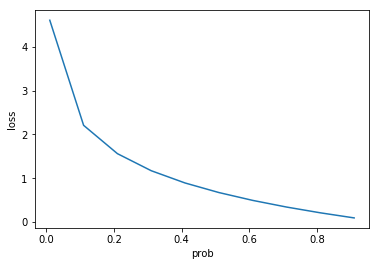

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

probs = np.arange(0.01,1,0.1)
reward = 1
loss = -reward*(np.log(probs))
plt.plot(probs, loss)
plt.ylabel('loss')
plt.xlabel('prob')